# Классификация заемщиков кредита с помощью логистической регрессии

## Московский физико-технический институт

### Соколов Игорь Александрович

## Постановка задачи

#### Задача

Классифицировать заемщиков кредита с помощью логистической регрессии. 

* Использовать алгоритм координтного спуска (реализован в стандартном солвере liblinear класса LogisticRegression ) .


* Рассмотреть регуляризаторы L1, L2, подобрать наилучшие параметры по метрике roc_auc

Пусть объекты описываются $n$ числовыми признаками:

$X \subseteq \mathbb{R}^n$ - пространство признаковых описаний объектов.

Y = \{+1, -1\} - множество меток классов.

Задана обучающая выборка: $\{(x_i, y_i)\}_1^l$

Наша задачи найти линейный алгоритм классификации:

$$a(x, w) = sign\langle w, x\rangle$$

Параметры $w$ и находятся, как решения следующей задачи оптимизации:

L2-regularization:

$$ Q(X, y) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i) ) ) \longrightarrow \min\limits_{w,b} $$

L1-regularization:

$$ Q(X, y) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i ) ) ) \longrightarrow \min\limits_{w,b} $$

$C$ - это стандартный гиперпараметр модели, который регулирует то, насколько сильно мы позволяем модели подстраиваться под данные.


## Обзор данных

In [579]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedKFold, KFold


%matplotlib inline

In [580]:
df = pd.read_csv('data.csv')
df.head(5)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


* **A2, A3, A8, A11, A14, A15**: вещественные.
* **A1**:	b, a. 
* **A4**:	u, y, l, t. 
* **A5**:	g, p, gg. 
* **A6**:	c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff. 
* **A7**:	v, h, bb, j, n, z, dd, ff, o. 
* **A9, A10, A12**:	t, f.  
* **A13**:	g, p, s. 

* **A16**: +,- атрибут класса


Так как некоторые и признаков категориальные, то для для построения линейной модели необходима предобработка. 

## Измерение качества

<img src="dts.png">
<img src="cv.jpeg">


## Предобработка данных

In [581]:
X = df.drop('A16', 1)
y = df['A16']

In [582]:
numeric_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']    
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))    

In [583]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

### Обработка пропущенных значений и преобразование вещественных признаков

На место пропуска можно вставить либо среднее по столбцу либо 0.

Далее рассмотрим два варианта.

In [584]:
X['A2'] = X['A2'].apply(lambda x: np.NaN if x =='?' else x)
X['A14'] = X['A14'].apply(lambda x: np.NaN if x =='?' else x)

X_num_float = X[numeric_cols].astype(float)
nan_id = np.argwhere(np.isnan(X_num_float['A14'].values))

X_real_zeros = X_num_float.fillna(0.0)
X_real_mean = X_num_float.fillna(calculate_means(X_num_float))

X_cat = X[categorical_cols].astype(str)

#Преобразование ответов
y_num = y.apply(lambda x: 1 if x=='+' else -1)

### Преобразование категориальных признаков

In [585]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

In [586]:
(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y_num, 
                                     test_size=0.2, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.2, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.2, 
                                   random_state=0)

### Стандартизация

Построим гистограммы для вещественных признаков.

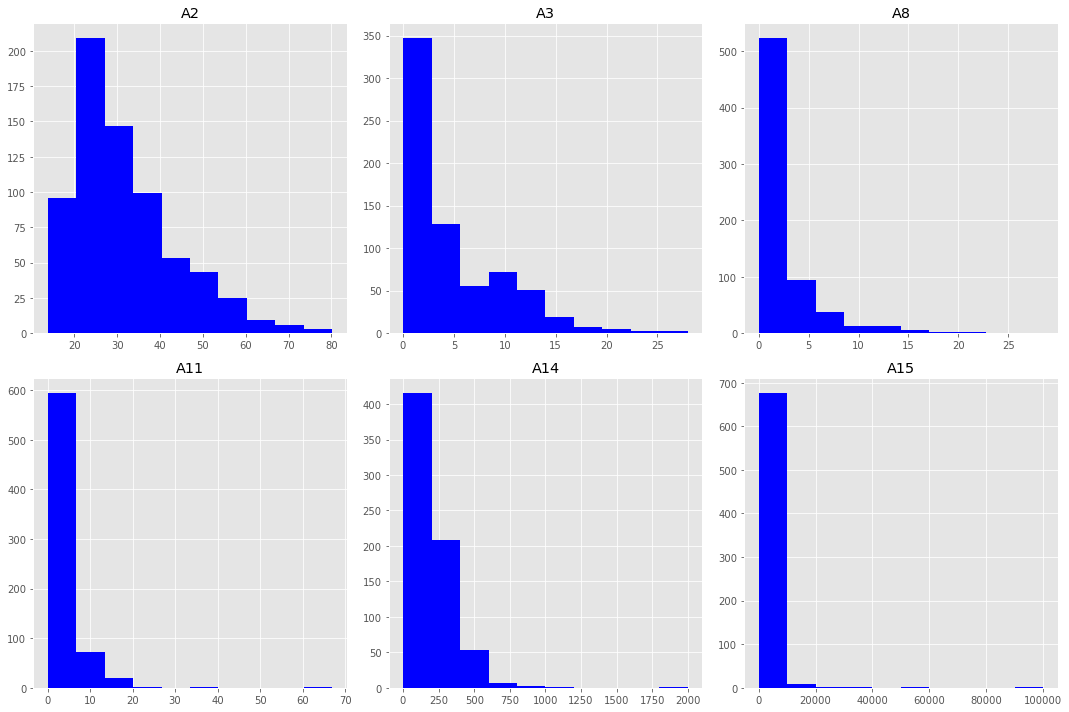

In [587]:
n_bins = 10
x = np.random.randn(1000, 3)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax[i].hist(X_real_mean[col].values, n_bins, color="blue")
    ax[i].legend(prop={'size': 10})
    ax[i].set_title(col)

fig.tight_layout()
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений. 

При использовании регуляризации, которая штрафует модель за большие веса, это разброс начинает сказываться и регрессия, как правило, начинает работать хуже.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{i} = \dfrac{x_{i} - \mu}{\sigma}, \quad \mu = \frac{1}{N} \sum_{i=1}^l x_{i}, \quad \sigma = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{i} - \mu)^2} $$

$\mu$ и $\sigma$ вычисляется именно по тренировочным данным.

Мы считаем, что и тренировочные и тестовые данные находится в одном распределении, поэтому делаем преобразование над тестовой выборкой с такими же $\mu$ и $\sigma$

In [588]:
def plot_scores(optimizer1, optimizer2, title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    optimizer2_mean
    scores1 = [[item[0]['C'], item[1], 
(np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer1.grid_scores_]
    scores1 = np.array(scores1)
    ax1.semilogx(scores1[:,0], scores1[:,1])
    ax1.fill_between(scores1[:,0], scores1[:,1]-scores1[:,2], 
                                  scores1[:,1]+scores1[:,2], alpha=0.3)
    ax1.set_ylabel('ROC-AUC')
    ax1.set_xlabel('C')
    ax1.set_title(title[0])
    
    scores2 = [[item[0]['C'], item[1], 
(np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer2.grid_scores_]
    scores2 = np.array(scores2)
    ax2.semilogx(scores2[:,0], scores2[:,1])
    ax2.fill_between(scores2[:,0], scores2[:,1]-scores2[:,2], 
                                  scores2[:,1]+scores2[:,2], alpha=0.3)
    ax2.set_ylabel('ROC-AUC')
    ax2.set_xlabel('C')
    ax2.set_title(title[1])
    plt.show()

In [589]:
def plot_roc(fpr, tpr, label,color):
    fig  = plt.figure(figsize=(15,10))
    for i in range(len(tpr)):
        plt.plot(fpr[i], tpr[i], label=label[i], color=color[i])
    plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")
    plt.show()

In [590]:
X_train_zeros = np.hstack((X_train_real_zeros, X_train_cat_oh))
X_test_zeros  = np.hstack((X_test_real_zeros,  X_test_cat_oh))

X_train_mean = np.hstack((X_train_real_mean, X_train_cat_oh))
X_test_mean  = np.hstack((X_test_real_mean,  X_test_cat_oh))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train_real_zeros, y_train)
X_train_real_zeros_scaled = scaler.transform(X_train_real_zeros)
X_test_real_zeros_scaled  = scaler.transform(X_test_real_zeros)

scaler.fit(X_train_real_mean, y_train)
X_train_real_mean_scaled = scaler.transform(X_train_real_mean)
X_test_real_mean_scaled = scaler.transform (X_test_real_mean)

X_train_zeros_scaled = np.hstack((X_train_real_zeros_scaled, X_train_cat_oh))
X_test_zeros_scaled = np.hstack((X_test_real_zeros_scaled, X_test_cat_oh))

X_train_mean_scaled = np.hstack ((X_train_real_mean_scaled, X_train_cat_oh))
X_test_mean_scaled = np.hstack((X_test_real_mean_scaled, X_test_cat_oh))

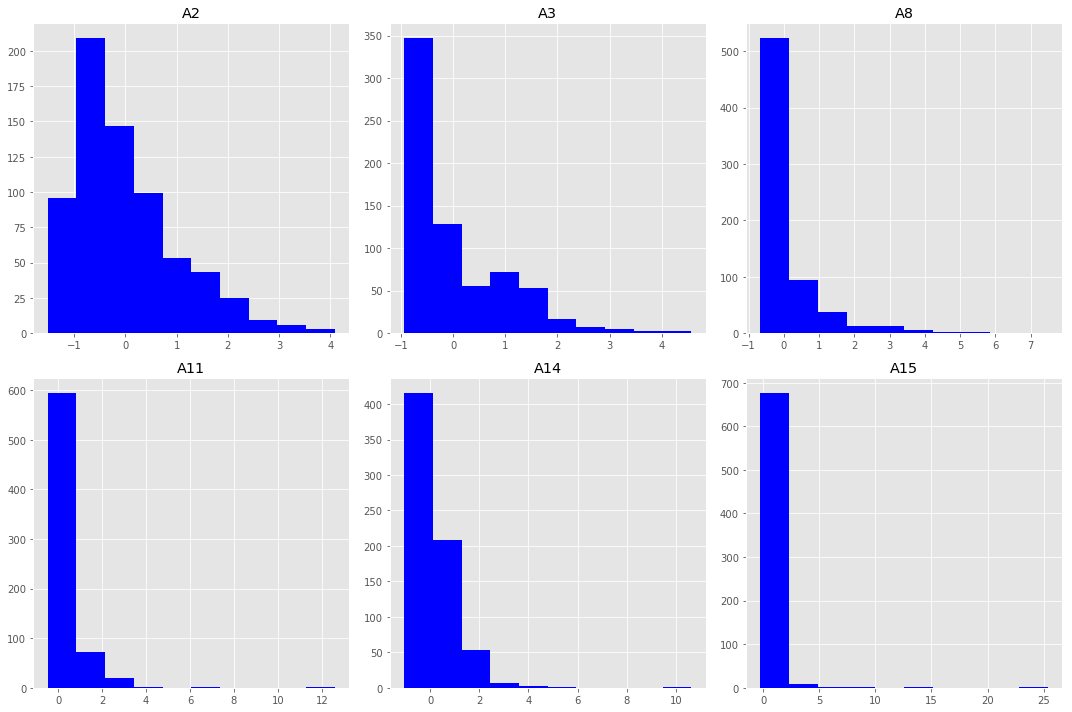

In [591]:
n_bins = 10

XX = np.vstack((X_train_mean_scaled, X_test_mean_scaled))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax[i].hist(XX[:,i], n_bins, color="blue")
    ax[i].legend(prop={'size': 10})
    ax[i].set_title(col)

fig.tight_layout()
plt.show()

## Обучение

In [592]:
C = np.arange(0.01, 50.0, 0.5)
param_grid = {'C': C, 'solver':['liblinear']}
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=0)

est2_m = LR('l2')
est2_z = LR('l2')
est2_ms = LR('l2')
est2_zs = LR('l2')


opt2_m = GridSearchCV(est2_m,param_grid,scoring = 'roc_auc',cv=cv)
opt2_z = GridSearchCV(est2_z,param_grid,scoring = 'roc_auc',cv=cv)

opt2_ms = GridSearchCV(est2_ms,param_grid,scoring = 'roc_auc',cv=cv)
opt2_zs = GridSearchCV(est2_zs,param_grid,scoring = 'roc_auc',cv=cv)


In [593]:
opt2_z.fit(X_train_zeros,y_train)
opt2_m.fit(X_train_mean,y_train)

opt2_zs.fit(X_train_zeros_scaled,y_train)
opt2_ms.fit(X_train_mean_scaled,y_train)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1 -1 ...,  1 -1], n_folds=5, shuffle=True, random_state=0),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   5.10000e-01, ...,   4.90100e+01,   4.95100e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

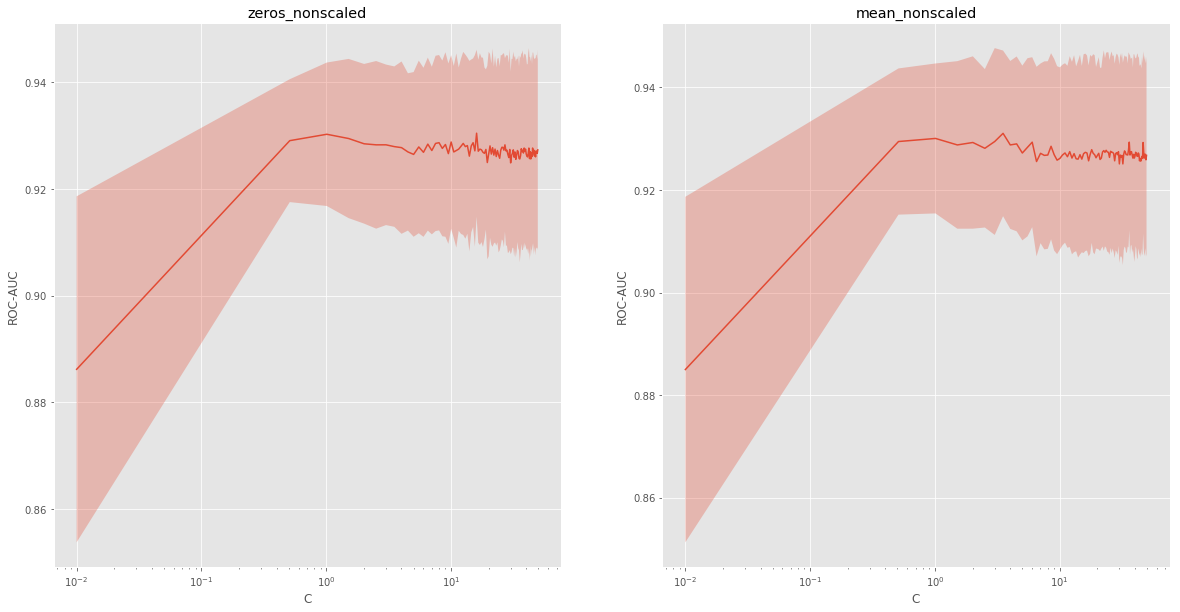

In [594]:
plot_scores(opt2_z, opt2_m,["zeros_nonscaled","mean_nonscaled"])

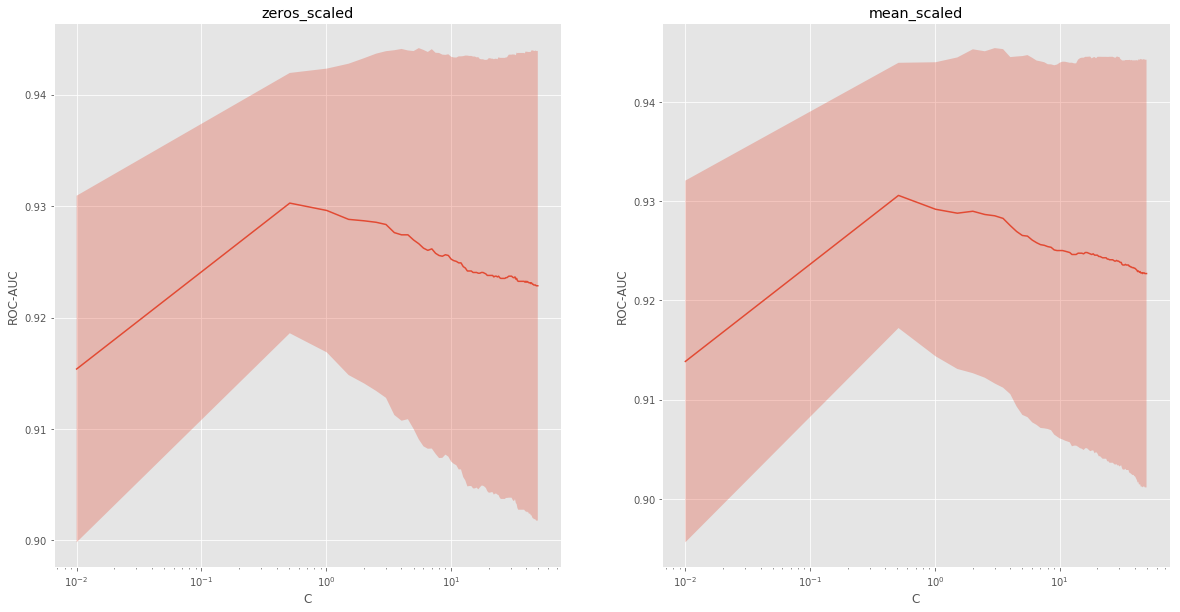

In [595]:
plot_scores(opt2_zs, opt2_ms,["zeros_scaled","mean_scaled"])

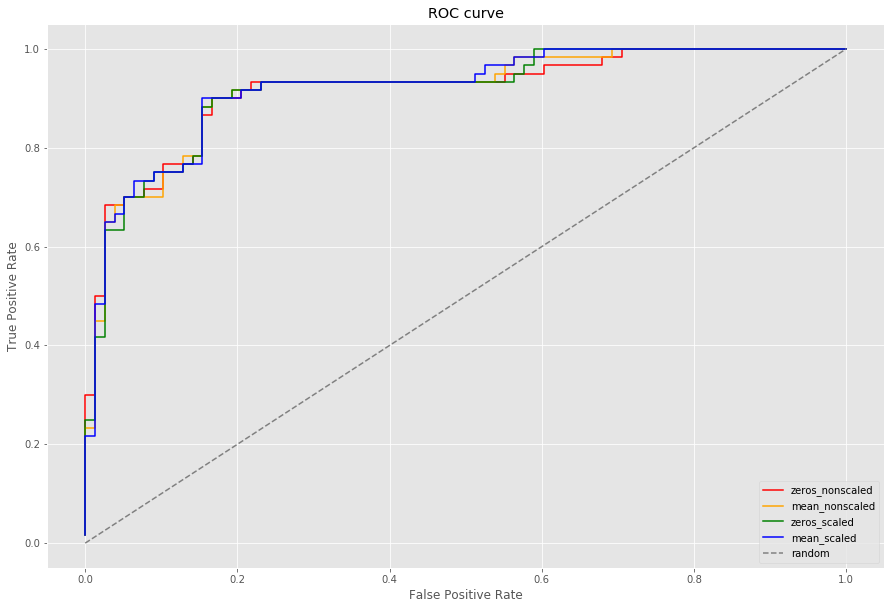

In [596]:
fpr1, tpr1, _ = roc_curve(y_test, opt2_z.predict_proba(X_test_zeros)[:,1])
fpr2, tpr2, _ = roc_curve(y_test, opt2_m.predict_proba(X_test_mean)[:,1])

fpr3, tpr3, _ = roc_curve(y_test, opt2_zs.predict_proba(X_test_zeros_scaled)[:,1])
fpr4, tpr4, _ = roc_curve(y_test, opt2_ms.predict_proba(X_test_mean_scaled)[:,1])

plot_roc((fpr1,fpr2, fpr3,fpr4), (tpr1, tpr2,tpr3, tpr4), 
("zeros_nonscaled","mean_nonscaled", "zeros_scaled","mean_scaled"), ("red","orange","green","blue"))


In [606]:
print "Для zeros_nonscaled"
print "Лучший ROC-AUC на обучении: ", round(opt2_z.best_score_, 4)
print "Лучший ROC-AUC на отложенной выборке: ",  round(roc_auc_score(y_test, opt2_z.predict(X_test_zeros)), 4)
print "С: ", est2_z.C
print"\n"
print "Для mean_nonscaled"
print "Лучший ROC-AUC на обучении: ", round(opt2_m.best_score_, 4)
print "Лучший ROC-AUC на отложенной выборке: ",  round(roc_auc_score(y_test, opt2_m.predict(X_test_mean)), 4)
print "С: ", est2_m.C
print"\n"
print "Для zeros_scaled"
print "Лучший ROC-AUC на обучении: ", round(opt2_zs.best_score_, 4)
print "Лучший ROC-AUC на отложенной выборке: ",  round(roc_auc_score(y_test, opt2_zs.predict(X_test_zeros_scaled)), 4)
print "С: ", est2_zs.C
print"\n"
print "Для mean_scaled"
print "Лучший ROC-AUC на обучении: ", round(opt2_ms.best_score_, 4)
print "Лучший ROC-AUC на отложенной выборке: ",  round(roc_auc_score(y_test, opt2_ms.predict(X_test_mean_scaled)), 4)
print "С: ", est1_ms.C

Для zeros_nonscaled
Лучший ROC-AUC на обучении:  0.9305
Лучший ROC-AUC на отложенной выборке:  0.8147
С:  1.0


Для mean_nonscaled
Лучший ROC-AUC на обучении:  0.9311
Лучший ROC-AUC на отложенной выборке:  0.8397
С:  1.0


Для zeros_scaled
Лучший ROC-AUC на обучении:  0.9303
Лучший ROC-AUC на отложенной выборке:  0.8397
С:  1.0


Для mean_scaled
Лучший ROC-AUC на обучении:  0.9306
Лучший ROC-AUC на отложенной выборке:  0.8314
С:  1.0


Возрос auc_roc на на той выборке, что мы ранее заполнили нулями

### Попробуем L1-регуляризацию

In [598]:
C = np.arange(0.01, 50.0, 0.5)
param_grid = {'C': C, 'solver':['liblinear']}
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=0)

est1_m  = LR('l1')
est1_z  = LR('l1')
est1_ms = LR('l1')
est1_zs = LR('l1')

opt1_m = GridSearchCV(est1_m, param_grid,scoring = 'roc_auc',cv=cv)
opt1_z = GridSearchCV(est1_z, param_grid,scoring = 'roc_auc',cv=cv)

opt1_ms = GridSearchCV(est1_ms, param_grid,scoring = 'roc_auc',cv=cv)
opt1_zs = GridSearchCV(est1_zs, param_grid,scoring = 'roc_auc',cv=cv)

In [599]:
opt1_z.fit(X_train_zeros, y_train)
opt1_m.fit(X_train_mean, y_train)

opt1_zs.fit(X_train_zeros_scaled, y_train)
opt1_ms.fit(X_train_mean_scaled, y_train)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1 -1 ...,  1 -1], n_folds=5, shuffle=True, random_state=0),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   5.10000e-01, ...,   4.90100e+01,   4.95100e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

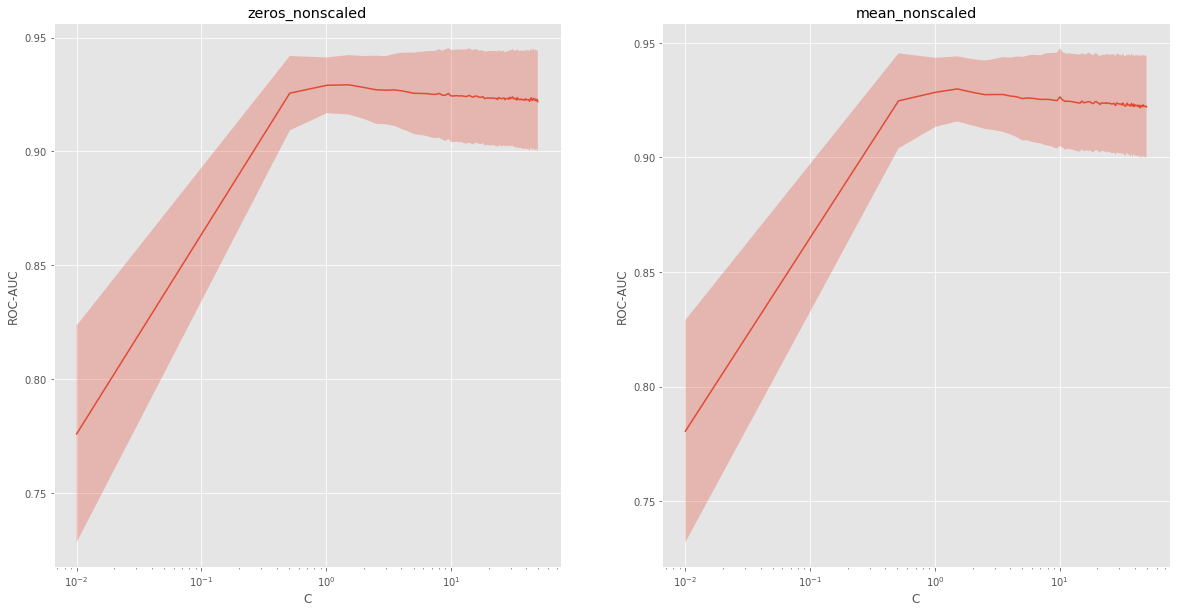

In [600]:
plot_scores(opt1_z, opt1_m,["zeros_nonscaled","mean_nonscaled"])

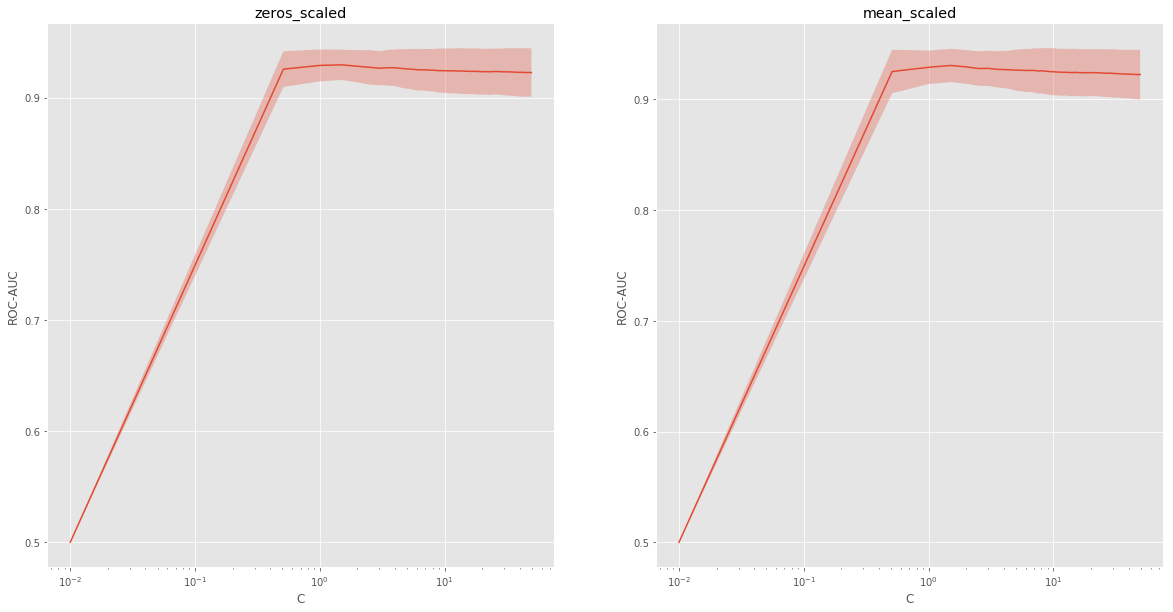

In [601]:
plot_scores(opt1_zs, opt1_ms,["zeros_scaled","mean_scaled"])

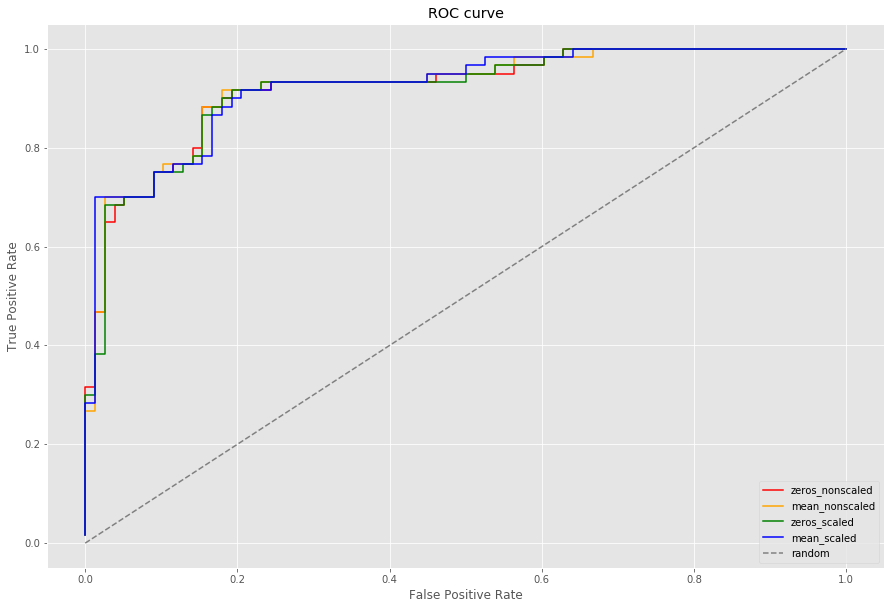

In [602]:
fpr1, tpr1, _ = roc_curve(y_test, opt1_z.predict_proba(X_test_zeros)[:,1])
fpr2, tpr2, _ = roc_curve(y_test, opt1_m.predict_proba(X_test_mean)[:,1])

fpr3, tpr3, _ = roc_curve(y_test, opt1_zs.predict_proba(X_test_zeros_scaled)[:,1])
fpr4, tpr4, _ = roc_curve(y_test, opt1_ms.predict_proba(X_test_mean_scaled)[:,1])

plot_roc((fpr1,fpr2, fpr3,fpr4), (tpr1, tpr2,tpr3, tpr4), 
("zeros_nonscaled","mean_nonscaled", "zeros_scaled","mean_scaled"), ("red","orange","green","blue"))


In [604]:
print "Для zeros_nonscaled"
print "Лучший ROC-AUC на обучении: ", round(opt1_z.best_score_, 4)
print "Лучший ROC-AUC на отложенной выборке: ",  round(roc_auc_score(y_test, opt1_z.predict(X_test_zeros)), 4)
print "С: ", est1_z.C
print"\n"
print "Для mean_nonscaled"
print "Лучший ROC-AUC на обучении: ", round(opt1_m.best_score_, 4)
print "Лучший ROC-AUC на отложенной выборке: ",  round(roc_auc_score(y_test, opt1_m.predict(X_test_mean)), 4)
print "С: ", est1_m.C
print"\n"
print "Для zeros_scaled"
print "Лучший ROC-AUC на обучении: ", round(opt1_zs.best_score_, 4)
print "Лучший ROC-AUC на отложенной выборке: ",  round(roc_auc_score(y_test, opt1_zs.predict(X_test_zeros_scaled)), 4)
print "С: ", est1_zs.C
print"\n"
print "Для mean_scaled"
print "Лучший ROC-AUC на обучении: ", round(opt1_ms.best_score_, 4)
print "Лучший ROC-AUC на отложенной выборке: ",  round(roc_auc_score(y_test, opt1_ms.predict(X_test_mean_scaled)), 4)
print "С: ", est1_ms.C

Для zeros_nonscaled
Лучший ROC-AUC на обучении:  0.9293
Лучший ROC-AUC на отложенной выборке:  0.8314
С:  1.0


Для mean_nonscaled
Лучший ROC-AUC на обучении:  0.9299
Лучший ROC-AUC на отложенной выборке:  0.8231
С:  1.0


Для zeros_scaled
Лучший ROC-AUC на обучении:  0.9295
Лучший ROC-AUC на отложенной выборке:  0.8397
С:  1.0


Для mean_scaled
Лучший ROC-AUC на обучении:  0.9305
Лучший ROC-AUC на отложенной выборке:  0.825
С:  1.0


Стандартизация повысила roc-auc на обоих выборках.

Столь малое влияние нормализации в обоих случаях проявляется потому, что элементов с большим отклоением в исходной выборке было мало  

### Заключение:
* При фиксированном солвере посмотрели как ведет себя 